In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import pathlib
import pandas as pd
from PIL import Image 
from PIL.ImageDraw import Draw

In [5]:
width = 216
height = 216
num_classes = 2
classes = ["Circle", "No-Circle"]

In [6]:
TRAINING_CSV_FILE = 'Data/training_data.csv'
TESTING_CSV_FILE = 'Data/testing_data.csv'
TRAINING_IMAGE_DIR = 'Images/Training'
TESTING_IMAGE_DIR = 'Images/Testing'

training_image_records = pd.read_csv(TRAINING_CSV_FILE)
testing_image_records = pd.read_csv(TESTING_CSV_FILE)

train_image_path = os.path.join(os.getcwd(), TRAINING_IMAGE_DIR)
test_image_path = os.path.join(os.getcwd(), TESTING_IMAGE_DIR)

train_images = []
train_targets = []
train_labels = []

for index, row in training_image_records.iterrows():
    
    (filename, width, height, class_name, xmin, ymin, xmax, ymax) = row
    
    train_image_fullpath = os.path.join(train_image_path, filename)
    train_img = keras.preprocessing.image.load_img(train_image_fullpath, target_size=(height, width))
    train_img_arr = keras.preprocessing.image.img_to_array(train_img)
    
    
    xmin = round(xmin/ width, 2)
    ymin = round(ymin/ height, 2)
    xmax = round(xmax/ width, 2)
    ymax = round(ymax/ height, 2)
    
    train_images.append(train_img_arr)
    train_targets.append((xmin, ymin, xmax, ymax))
    train_labels.append(classes.index(class_name))
    
    
    
test_images = []
test_targets = []
test_labels = []

for index, row in testing_image_records.iterrows():
    
    (filename, width, height, class_name, xmin, ymin, xmax, ymax) = row
    
    test_image_fullpath = os.path.join(test_image_path, filename)
    test_img = keras.preprocessing.image.load_img(test_image_fullpath, target_size=(height, width))
    test_img_arr = keras.preprocessing.image.img_to_array(test_img)
    #img_arr = img_arr/255.0
    
    xmin = round(xmin/ width, 2)
    ymin = round(ymin/ height, 2)
    xmax = round(xmax/ width, 2)
    ymax = round(ymax/ height, 2)
    
    test_images.append(test_img_arr)
    test_targets.append((xmin, ymin, xmax, ymax))
    test_labels.append(classes.index(class_name))

In [7]:
#create the common input layer
input_shape = (height, width, 3)
input_layer = tf.keras.layers.Input(input_shape)

In [22]:
base_layers = layers.experimental.preprocessing.Rescaling(1./255, name='bl_1')(input_layer)
base_layers = layers.Conv2D(16, 3, padding='same', activation='relu', name='bl_2')(base_layers)
base_layers = layers.MaxPooling2D(name='bl_3')(base_layers)
base_layers = layers.Conv2D(32, 3, padding='same', activation='relu', name='bl_4')(base_layers)
base_layers = layers.MaxPooling2D(name='bl_5')(base_layers)
base_layers = layers.Conv2D(64, 3, padding='same', activation='relu', name='bl_6')(base_layers)
base_layers = layers.MaxPooling2D(name='bl_7')(base_layers)
base_layers = layers.Flatten(name='bl_8')(base_layers)

classifier_branch = layers.Dense(128, activation='relu', name='cl_1')(base_layers)
classifier_branch = layers.Dense(num_classes, name='cl_classifier_head')(classifier_branch)  

locator_branch = layers.Dense(128, activation='relu', name='bb_1')(base_layers)
locator_branch = layers.Dense(64, activation='relu', name='bb_2')(locator_branch)
locator_branch = layers.Dense(32, activation='relu', name='bb_3')(locator_branch)
locator_branch = layers.Dense(4, activation='sigmoid', name='bb_bbox_head')(locator_branch)

In [25]:
model = tf.keras.Model(input_layer, outputs=[classifier_branch, locator_branch])

In [26]:
#for layer in model.layers:
#    if layer.name.startswith('cl'):
#        print(layer.name)
#        layer.trainable = False

In [12]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 216, 216, 3) 0                                            
__________________________________________________________________________________________________
bl_1 (Rescaling)                (None, 216, 216, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
bl_2 (Conv2D)                   (None, 216, 216, 16) 448         bl_1[0][0]                       
__________________________________________________________________________________________________
bl_3 (MaxPooling2D)             (None, 108, 108, 16) 0           bl_2[0][0]                       
______________________________________________________________________________________________

In [13]:
losses = {"classifier_head":tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), "bbox_head":tf.keras.losses.MSE}


In [16]:
model.compile(loss=losses, optimizer='Adam', metrics=['accuracy'])

In [17]:
training_epochs = 20

train_images = np.array(train_images)
train_targets = np.array(train_targets)
train_labels = np.array(train_labels)

test_images = np.array(test_images)
test_targets = np.array(test_targets)
test_labels = np.array(test_labels)

In [18]:
trainTargets = {
    "classifier_head": train_labels,
    "bbox_head": train_targets
}

testTargets = {
    "classifier_head": test_labels,
    "bbox_head": test_targets
}

In [21]:
print(type(trainTargets))

<class 'dict'>


In [15]:
history = model.fit(train_images, trainTargets,
                   validation_data=(test_images, testTargets),
                   batch_size=4,
                   epochs=training_epochs,
                   shuffle=True,
                   verbose=1)

Epoch 1/20
28/28 [==============================] - 13s 457ms/step - loss: 0.0807 - classifier_head_loss: 0.0272 - bbox_head_loss: 0.0535 - classifier_head_accuracy: 0.9643 - bbox_head_accuracy: 0.4464 - val_loss: 0.0362 - val_classifier_head_loss: 7.9944e-05 - val_bbox_head_loss: 0.0361 - val_classifier_head_accuracy: 1.0000 - val_bbox_head_accuracy: 0.6429
Epoch 2/20
28/28 [==============================] - 13s 452ms/step - loss: 0.0293 - classifier_head_loss: 4.2930e-05 - bbox_head_loss: 0.0293 - classifier_head_accuracy: 1.0000 - bbox_head_accuracy: 0.6250 - val_loss: 0.0126 - val_classifier_head_loss: 5.3119e-08 - val_bbox_head_loss: 0.0126 - val_classifier_head_accuracy: 1.0000 - val_bbox_head_accuracy: 0.4286
Epoch 3/20
28/28 [==============================] - 13s 453ms/step - loss: 0.0126 - classifier_head_loss: 1.1140e-07 - bbox_head_loss: 0.0126 - classifier_head_accuracy: 1.0000 - bbox_head_accuracy: 0.8036 - val_loss: 0.0050 - val_classifier_head_loss: 0.0000e+00 - val_bbox

In [27]:
test_img = 'Test/20210620_155802.jpg'

img = keras.preprocessing.image.load_img(test_img, target_size=(height, width))

img = keras.preprocessing.image.img_to_array(img)
img = tf.expand_dims(img, 0)
predictions = model.predict(img)

In [28]:
print(predictions[1][0])

[0.47640175 0.332181   0.74886024 0.56987053]


In [29]:
bbox = predictions[1][0]
bbox = [bbox[0] * width, bbox[1] * height, bbox[2] * width, bbox[3] * height]
print(bbox)

class_prediction_value = predictions[0][0]
score = tf.nn.softmax(class_prediction_value)

print(score)
score = tf.math.argmax(score)
print("Predicted class: {}".format(classes[score]))

[102.9027771949768, 71.7510974407196, 161.75381183624268, 123.09203481674194]
tf.Tensor([1.0000000e+00 3.8923112e-08], shape=(2,), dtype=float32)
Predicted class: Circle


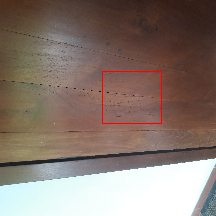

In [30]:
testimg = keras.preprocessing.image.load_img(test_img, target_size=(height, width))
draw1 = Draw(testimg)
draw1.rectangle(bbox, outline='red')
testimg

In [31]:
model.save('./Saved-Models/Locator')

INFO:tensorflow:Assets written to: ./Saved-Models/Locator/assets
